## Random forest classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

---
**Confusion matrix**

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix.

https://en.wikipedia.org/wiki/Confusion_matrix

http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

---


  * The true-positive rate is also known as sensitivity, or recall in machine learning.
  * The false-positive rate is also known as the fall-out and can be calculated as (1 - specificity)

**True positive rate**

```
 number of true positives     number correctly predicted positive
-------------------------- = -------------------------------------
 number of positive cases           number of positive cases
```

**False positive rate**

```
 number of false positives     number incorrectly predicted positive
--------------------------- = ---------------------------------------
  number of negative cases           number of negative cases
```
---
**Recall**

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.


Intuitively, precision is the ability of the classifier not to label as positive a sample that is negative, and recall is the ability of the classifier to find all the positive samples.

The F-measure (F_\beta and F_1 measures) can be interpreted as a weighted harmonic mean of the precision and recall. A F_\beta measure reaches its best value at 1 and its worst score at 0. With \beta = 1, F_\beta and F_1 are equivalent, and the recall and the precision are equally important.

The precision_recall_curve computes a precision-recall curve from the ground truth label and a score given by the classifier by varying a decision threshold.

The average_precision_score function computes the average precision (AP) from prediction scores. This score corresponds to the area under the precision-recall curve. The value is between 0 and 1 and higher is better. With random predictions, the AP is the fraction of positive samples.

https://en.wikipedia.org/wiki/Receiver_operating_characteristic


---
**Standardize features**

by removing the mean and scaling to unit variance

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

This scaler can also be applied to sparse CSR or CSC matrices by passing with_mean=False to avoid breaking the sparsity structure of the data.

---
**KFold** 

Divides all the samples in k groups of samples, called folds (if k = n, this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using k - 1 folds, and the fold left out is used for test.

http://scikit-learn.org/stable/modules/cross_validation.html

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

from scipy.stats import itemfreq
from scipy import interp

from prettytable import PrettyTable
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('seaborn-deep')
matplotlib.style.use('ggplot')

%matplotlib inline

/Users/eloisaelias/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


DeprecationWaring:

http://scikit-learn.org/stable/whats_new.html

In [7]:
df = pd.read_csv('data/churn.csv')

In [8]:
df[:2]

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Int'l Plan        3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 546.9+ KB


In [10]:
pd.set_option('display.max_columns', None)

In [11]:
df[:2]

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.


In [12]:
df["Int'l Plan"].unique()

array(['no', 'yes'], dtype=object)

In [13]:
# object to boolean
df["Int'l Plan"] = df["Int'l Plan"] == 'yes'

In [14]:
df['VMail Plan'].unique()

array(['yes', 'no'], dtype=object)

In [15]:
df['VMail Plan'] = df['VMail Plan'] == 'yes'

In [16]:
df['Churn?'].unique()

array(['False.', 'True.'], dtype=object)

In [17]:
df['Churn?'] = df['Churn?'] == 'True.'

In [18]:
df[:2]

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,OH,107,415,371-7191,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [19]:
df = df.drop(['State', 'Area Code', 'Phone'], axis=1)

In [20]:
df[:2]

,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,128,False,True,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False
1,107,False,True,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False


In [21]:
y = df.pop('Churn?').values

In [22]:
feature_names = df.columns
feature_names

Index([u'Account Length', u'Int'l Plan', u'VMail Plan', u'VMail Message',
       u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls',
       u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge',
       u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls'],
      dtype='object')

In [23]:
X = df.values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
modelrf = RandomForestClassifier()
modelrf.fit(X_train, y_train)
yhat = modelrf.predict(X_test)

In [26]:
acc = np.sum(yhat == y_test)/float(len(y_test)) 
acc

0.96522781774580335

In [27]:
cmatrix = confusion_matrix(y_test, yhat)
cmatrix

array([[727,   3],
       [ 26,  78]])

In [28]:
pd.DataFrame(cmatrix, columns = ['Predicted False (Negative)', 'Predicted True (Positive)'], index=['True Condition: False (Negative)', 'True Codition: True (Positive)'])

,Predicted False (Negative),Predicted True (Positive)
True Condition: False (Negative),727,3
True Codition: True (Positive),26,78


In [29]:
TN = cmatrix[0][0]
FP = cmatrix[0][1]
FN = cmatrix[1][0]
TP = cmatrix[1][1]

In [30]:
print TN, FP
print FN, TP

727 3
26 78


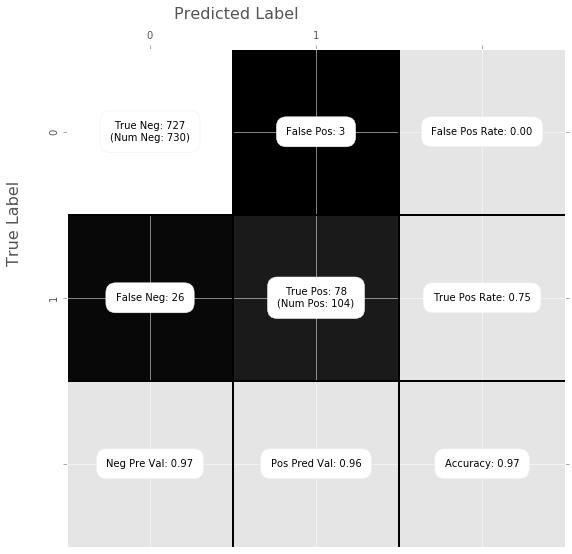

In [34]:
tn, fn, fp, tp, NN, NP, FPR, TPR, NPV, PPV, Acc = show_confusion_matrix_(cmatrix,class_labels=['0','1'])

In [35]:
print tn, fn, fp, tp, NN, NP, FPR, TPR, NPV, PPV, Acc

727 26 3 78 730 104 0.0 0.75 0.97 0.96 0.97


In [33]:
def show_confusion_matrix_(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    FPR = fp / (fp+tn+0.)
    TPR = tp / (tp+fn+0.)
    NPV = 1-fn/(fn+tn+0.)
    PPV = tp/(tp+fp+0.)
    Acc = (tp+tn+0.)/N
    
    plt.tight_layout()
    plt.show()
    
    return tn, fn, fp, tp, NN, NP, round(FPR,2), round(TPR, 2), round(NPV, 2), round(PPV, 2), round(Acc, 2)


In [36]:
precision = precision_score(y_test, yhat)
recall = recall_score(y_test, yhat)

In [37]:
print 'Precision: {:1.4f}'.format(precision)

Precision: 0.9630


In [38]:
print 'Recall: {:1.4f}'.format(recall)

Recall: 0.7500


In [39]:
model1 = RandomForestClassifier(n_estimators= 20, oob_score = True)
model1.fit(X_train, y_train)
yhat1 = model1.predict(X_test)

In [40]:
ooscore = model1.oob_score_
m1_acc = model1.score(X_test, y_test) 

In [41]:
print 'OOB score: {:1.4f}'.format(ooscore)
print 'Accuracy: {:1.4f}'.format(m1_acc)

OOB score: 0.9368
Accuracy: 0.9652


---
### Feature importance

In [42]:
feature_importance = pd.Series(model1.feature_importances_, index=feature_names)
feature_importance.sort_values(ascending=False).head(5)

Day Charge        0.137112
Day Mins          0.136019
CustServ Calls    0.116342
Eve Charge        0.078422
Int'l Plan        0.073673
dtype: float64

In [43]:
def acc_tree_plot(X_train, y_train, X_test, y_test, initree, stoptree, freq):
    acc = []
    trees = range(initree,stoptree, freq)
    
    for tree in trees:
        model = RandomForestClassifier(n_estimators=tree)
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        acc.append(accuracy)
     

    plt.plot(trees, acc, label= 'Test')
    plt.xlabel('Number of trees')
    plt.ylabel('Accuracy')
    plt.legend()
    


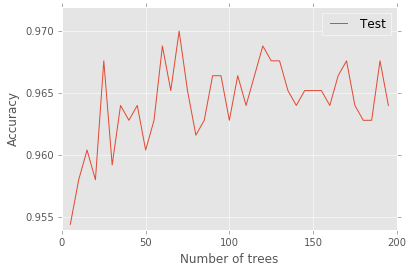

In [44]:
acc_tree_plot(X_train, y_train, X_test, y_test, 5, 200, 5)

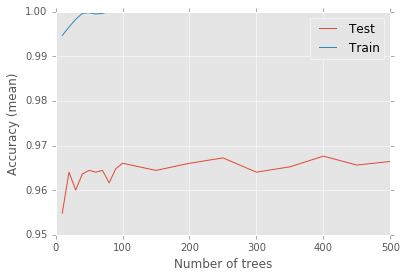

In [45]:
acc = []
acc_train = []
trees = range(10, 110, 10)+range(100, 550, 50)

for tree in trees:
    tree_acc = []
    tree_acc_train = []
    for forest in range(3):
        model = RandomForestClassifier(n_estimators=tree)
        model.fit(X_train, y_train)
        tree_acc.append(model.score(X_test, y_test))
        tree_acc_train.append(model.score(X_train, y_train))
    acc.append(np.mean(tree_acc))
    acc_train.append(np.mean(tree_acc_train))

plt.plot(trees, acc, label='Test')
plt.plot(trees, acc_train, label='Train')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy (mean)')
plt.legend()
plt.show()

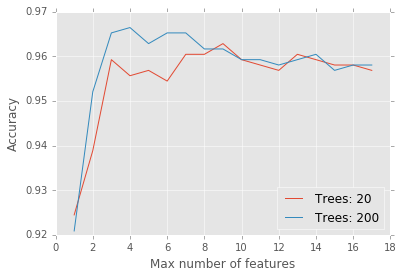

In [46]:
features = len(feature_names)
acc1, acc2 = [], []
for j in xrange(1, features+1, 1):
    rf1 = RandomForestClassifier(n_estimators=20, max_features=j)
    rf2 = RandomForestClassifier(n_estimators=200, max_features=j)
    rf1.fit(X_train, y_train)
    rf2.fit(X_train, y_train)
    acc1.append(rf1.score(X_test, y_test))
    acc2.append(rf2.score(X_test, y_test))

plt.plot(range(1, features+1, 1), acc1, label='Trees: 20')
plt.plot(range(1, features+1, 1), acc2, label='Trees: 200')
plt.xlabel('Max number of features')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [47]:
def max_features_optimization(X_train, y_train, X_test, y_test, estm1, estm2, feature_names):
    features = len(feature_names)
    acc1, acc2 = [], []
    for j in xrange(1, features+1, 1):
        rf1 = RandomForestClassifier(n_estimators=estm1, max_features=j)
        rf2 = RandomForestClassifier(n_estimators=estm2, max_features=j)
        rf1.fit(X_train, y_train)
        rf2.fit(X_train, y_train)
        acc1.append(rf1.score(X_test, y_test))
        acc2.append(rf2.score(X_test, y_test))

    plt.plot(range(1, features+1, 1), acc1, label='Trees: 20')
    plt.plot(range(1, features+1, 1), acc2, label='Trees: 200')
    plt.xlabel('Max number of features')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

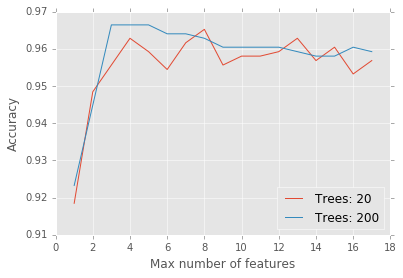

In [48]:
max_features_optimization(X_train, y_train, X_test, y_test, 20, 200, feature_names)

In [49]:
def testing_model(test_model, X_train, y_train, X_test, y_test, name, *args, **kwargs):
    model = test_model(*args, **kwargs)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    
    acc = model.score(X_test, y_test)
    preci = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    
    pretty = PrettyTable(['Metric', 'Score'])
    pretty.add_row(['Accuracy','{:1.4f}'.format(acc)])
    pretty.add_row(['Precision', '{:1.4f}'.format(preci)])
    pretty.add_row(['Recall', '{:1.4f}'.format(recall)])
    print(pretty)
    
    return pd.DataFrame({'Accuracy':acc, 'Precision':preci, 'Recall': recall}, index=[name])

In [50]:
logistic_score = testing_model(LogisticRegression, X_train, y_train, X_test, y_test, 'LogicReg')

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 0.8753 |
| Precision | 0.5000 |
|   Recall  | 0.2212 |
+-----------+--------+


In [51]:
logistic_score

,Accuracy,Precision,Recall
LogicReg,0.8753,0.5,0.221154


In [52]:
dt_score = testing_model(DecisionTreeClassifier, X_train, y_train, X_test, y_test, 'Dtree') 

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 0.9089 |
| Precision | 0.6129 |
|   Recall  | 0.7308 |
+-----------+--------+


In [53]:
dt_score

,Accuracy,Precision,Recall
Dtree,0.908873,0.612903,0.730769


In [54]:
knn_score = testing_model(KNeighborsClassifier, X_train, y_train, X_test, y_test, 'Knn')

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 0.8789 |
| Precision | 0.5246 |
|   Recall  | 0.3077 |
+-----------+--------+


In [55]:
knn_score

,Accuracy,Precision,Recall
Knn,0.878897,0.52459,0.307692


In [56]:
rf_score = testing_model(RandomForestClassifier, X_train, y_train, X_test, y_test, 'Rforest')

+-----------+--------+
|   Metric  | Score  |
+-----------+--------+
|  Accuracy | 0.9532 |
| Precision | 0.9221 |
|   Recall  | 0.6827 |
+-----------+--------+


In [57]:
rf_score

,Accuracy,Precision,Recall
Rforest,0.953237,0.922078,0.682692


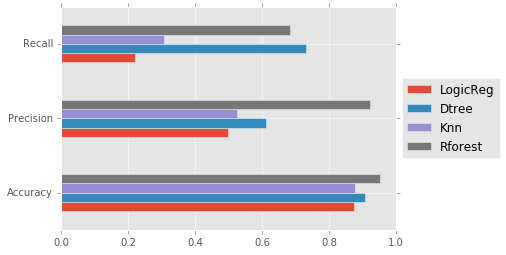

In [58]:
analizing = pd.concat([logistic_score, dt_score, knn_score, rf_score])
analizing.T.plot(kind='barh')
plt.legend(loc='center left', bbox_to_anchor=[1, .5])
plt.show()

In [117]:
def plot_roc_(X, y, clf_class, **kwargs):
    normalization = StandardScaler()
    X = normalization.fit_transform(X)
    kf = KFold(len(y), n_folds=5, shuffle=True)
    yprob = np.zeros((len(y), 2))
    tpr_mean = 0.0
    fpr_mean = np.linspace(0,1,100)
    
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        model = clf_class(**kwargs)
        model.fit(X_train, y_train)
        
        yprob[test_index] = model.predict_proba(X_test)
        fpr, tpr, threshold = roc_curve(y[test_index], yprob[test_index, 1])
        tpr_mean += interp(fpr_mean, fpr, tpr)
        tpr_mean[0]=0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold {} (area = {:1.2f})'.format(i, roc_auc))
    
    tpr_mean /= len(kf)
    tpr_mean[-1] = 1.0
    auc_mean = auc(fpr_mean, tpr_mean)
    
    plt.plot(fpr_mean, tpr_mean,'k--',label='Mean ROC (area = {:1.2f})'.format(auc_mean), lw=2)
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{}\n\nReceiver operating characteristic'.format(clf_class))
    plt.legend(loc="lower right")
    plt.show()
    
    

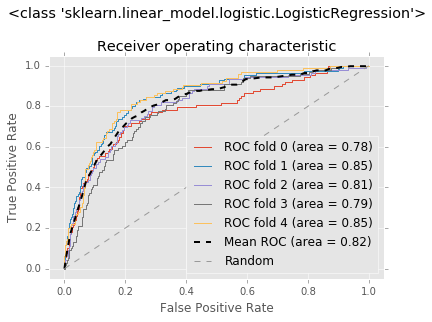

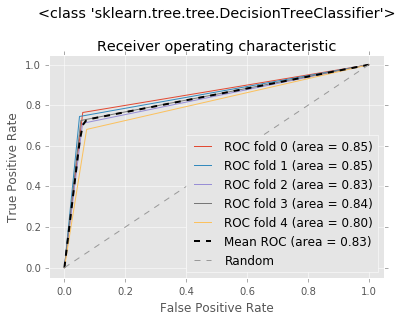

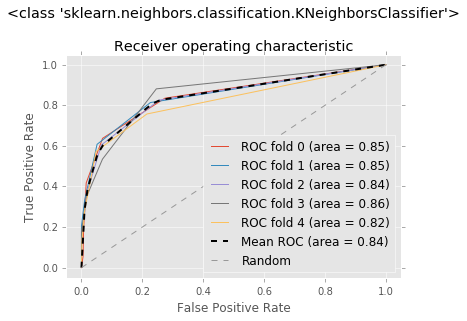

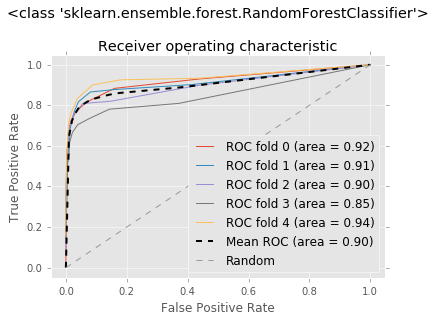

In [118]:
for model in (LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, RandomForestClassifier):
    plot_roc_(X.astype(float), y.astype(float), model)

In [119]:
model1.feature_importances_

array([ 0.03166537,  0.07367254,  0.01869868,  0.02830729,  0.13601948,
        0.0315647 ,  0.13711226,  0.06618107,  0.02761875,  0.0784218 ,
        0.04344393,  0.03179598,  0.03812471,  0.04809957,  0.0534698 ,
        0.03946211,  0.11634198])

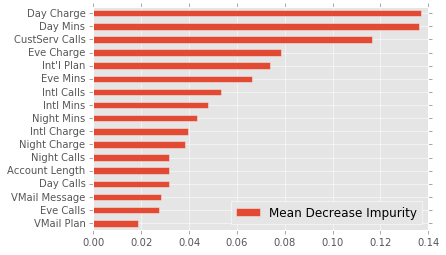

In [121]:
feature_score = pd.DataFrame({'Mean Decrease Gini Impurity': model1.feature_importances_}, index=feature_names)
feature_score = feature_score.sort_values('Mean Decrease Gini Impurity')
feature_score.plot(kind = 'barh');

In [154]:
std_dev = np.std([tree.feature_importances_ for tree in model1.estimators_], axis=0)
features_importance_ = pd.Series(model1.feature_importances_, index=None)
features_importance_.sort_values(ascending=False)
features_indexes = np.argsort(features_importance_)[::-1]
features_indexes

6     0.137112
4     0.136019
16    0.116342
9     0.078422
1     0.073673
7     0.066181
14    0.053470
13    0.048100
10    0.043444
15    0.039462
12    0.038125
11    0.031796
0     0.031665
5     0.031565
3     0.028307
8     0.027619
2     0.018699
dtype: float64

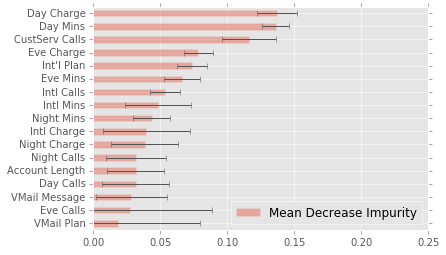

In [166]:
# error bars chart, where the width of the bars is the equal to the standard deviation for that feature.
feature_score.plot(kind='barh', xerr = std_dev[features_indexes], alpha=0.4)
plt.xlim(0, .25)
plt.show()